# Original vs simulated counts

This notebook tests the hypothesis that the VAE isn’t adequately accounting for low read counts. The VAE is artifically boosting the expression of these genes so that they are found to be DE.

In [1]:
%load_ext autoreload
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import ranking

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
project_id = params["project_id"]
col_to_rank_genes = params["rank_genes_by"]
template_filename = os.path.join(
    base_dir, dataset_name, params["processed_template_filename"]
)

# Directory containing simulated experiments
simulated_dir = os.path.join(local_dir, "pseudo_experiment")
run = 4

In [3]:
# Read template experiment
template = pd.read_csv(template_filename, sep="\t", index_col=0, header=0)

In [4]:
def scatter_plot_original_vs_simulated(
    ncols,
    nrows,
    fig_width,
    fig_height,
    num_simulated,
    by_sample_or_gene,
    gene_list=None,
):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, fig_height))
    axes = axes.ravel()

    if by_sample_or_gene == "sample":
        for i in range(num_simulated):
            # Get simulated filename
            simulated_filename = os.path.join(
                simulated_dir, f"selected_simulated_data_{project_id}_{i}_processed.txt"
            )

            # Read simulated experiment
            simulated = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

            # Create dataframe with columns
            # 1. Sample id
            # 2. Total counts across genes original (template)
            # 3. Total counts across genes after VAE (simulated)
            # Note the total counts is using all genes
            template_sample_counts = template.sum(axis=1)
            simulated_sample_counts = simulated.sum(axis=1)

            sample_counts = template_sample_counts.to_frame("Original counts").merge(
                simulated_sample_counts.to_frame("Simulated counts"),
                left_index=True,
                right_index=True,
            )

            # Plot per sample
            f = sns.scatterplot(
                data=sample_counts,
                x="Simulated counts",
                y="Original counts",
                alpha=0.8,
                ax=axes[i],
            )

            min_ = sample_counts.min().min()
            max_ = sample_counts.max().max()
            f.plot([min_, max_], [min_, max_], "k--")

            axes[i].set_ylabel("")
            axes[i].set_xlabel("")

        fig.text(
            0.5,
            0.0,
            "Simulated counts (after VAE)",
            ha="center",
            fontsize=14,
            fontname="Verdana",
        )
        fig.text(
            0.08,
            0.5,
            "Actual counts",
            va="center",
            rotation="vertical",
            fontsize=14,
            fontname="Verdana",
        )
        fig.suptitle(
            "Actual vs simulated counts per sample",
            fontsize=16,
            fontname="Verdana",
        )
    elif by_sample_or_gene == "gene":
        for i in range(num_simulated):
            # Get simulated filename
            simulated_filename = os.path.join(
                simulated_dir, f"selected_simulated_data_{project_id}_{i}_processed.txt"
            )

            # Read simulated experiment
            simulated = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

            # Create dataframe with columns
            # 1. Gene id
            # 2. Total counts across samples original (template)
            # 3. Total counts across samples after VAE (simulated)
            if gene_list is not None:
                template_gene_counts = template[gene_list].sum()
                simulated_gene_counts = simulated[gene_list].sum()
            else:
                template_gene_counts = template.sum()
                simulated_gene_counts = simulated.sum()

            gene_counts = template_gene_counts.to_frame("Original counts").merge(
                simulated_gene_counts.to_frame("Simulated counts"),
                left_index=True,
                right_index=True,
            )

            # Plot per sample
            g = sns.scatterplot(
                data=gene_counts,
                x="Simulated counts",
                y="Original counts",
                alpha=0.3,
                ax=axes[i],
            )

            # Note:
            # Attemplated to get hexbin plotting to take a look at the
            # density of points since they are piled on top of each other
            # But only seeing one color, not sure what the issue is here.
            # axes[i].hexbin(x=gene_counts["Simulated counts"],
            #               y=gene_counts["Original counts"],
            #               gridsize=100
            #              )
            # axes[i].set_ylim([0, 0.1e7])
            # axes[i].set_xlim([0, 0.1e7])

            min_ = gene_counts.min().min()
            max_ = gene_counts.max().max()
            g.plot([min_, max_], [min_, max_], "k--")
            g.plot([0, 0.1e7], [0, 0.1e7], "k--")
            axes[i].set_ylabel("")
            axes[i].set_xlabel("")

        fig.text(
            0.5,
            0.0,
            "Simulated counts (after VAE)",
            ha="center",
            fontsize=14,
            fontname="Verdana",
        )
        fig.text(
            0.08,
            0.5,
            "Actual counts",
            va="center",
            rotation="vertical",
            fontsize=14,
            fontname="Verdana",
        )
        fig.suptitle(
            "Actual vs simulated counts per gene",
            fontsize=16,
            fontname="Verdana",
        )

## Examine per sample total counts

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


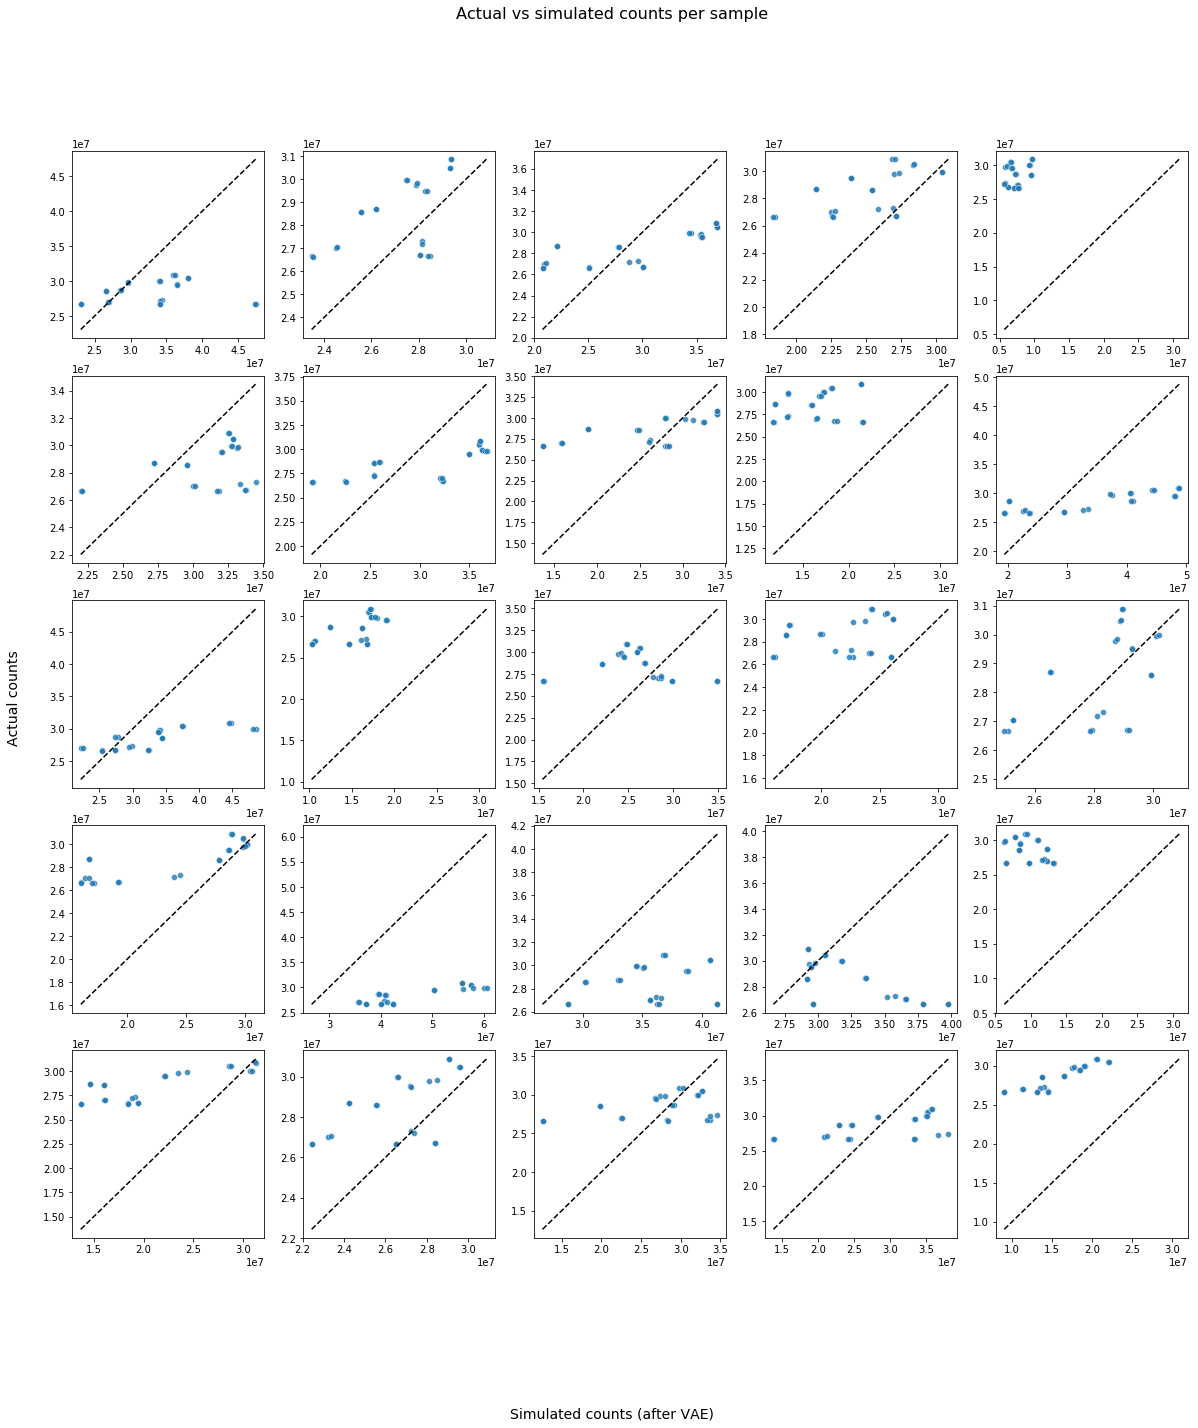

In [5]:
# Compare per sample
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="sample",
)

**Observations:**
* For about half of the cases, here is a horizontal trend that indicates that the variance in the actual total counts is lower compared to the simulated total counts. In other words the sequencing coverage of the actual experiment is consistent while the sequencing coverage of the simulated samples is variable.
* Overall, there are cases where most/all samples have a lower total read count in the simulated experiments compared to the actual experiment (when samples are all on one side of the diagonal). There are also cases where some samples have increased counts in the simulated experiment and some have decreased counts in the simulated experiment (i.e. when sample cross the diagonal).

* Ideally I would expect that the sequencing coverage of samples within a simulated experiment to be very tight (so not much spread horizontally. I would also expected that the sequencing coverage of the simulated experiment to be similar to the actual experiment, so the samples should cluster along the diagonal.

**Takeaway:**

 After going through the VAE shifting process, some samples seem to have increased or decreased sequencing coverage/depth (i.e. total read count) compared to the actual sample. DESeq will scale count estimates and give a higher prob of error for genes with a low sequence coverage/depth. If different simulated samples have different sequencing depth, then a gene can be found to be artificially DE due to the differences in sequencing coverage between samples as opposed to the condition tested.

To correct for this we can try to re-scale the decoded counts per sample so that the sum of the simulated counts is equal to the sum of the actual total counts.

Our expectation is that once we correct the simulated samples to have the same sequencing coverage as the actual samples, some of the DE genes in the simulated experiment will go away and we believe those are the ones that were specific to RNA-seq.

## Examine per sample counts for subsets of genes

In [6]:
# Load gene_summary_filename
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}.tsv"
)

summary_gene_ranks = pd.read_csv(gene_summary_filename, sep="\t", index_col=0, header=0)

r = 0.1851597404594152
p = 3.711325673092676e-132
ci_low = 0.17114685052590287
ci_high = 0.20052217799830116


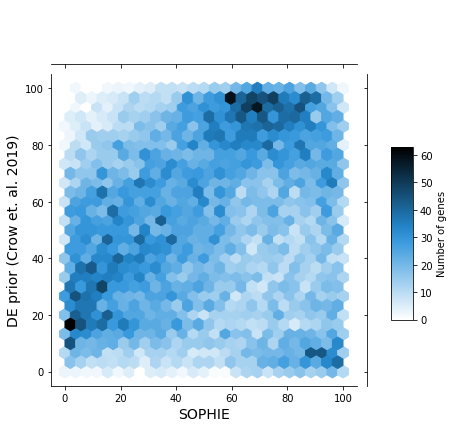

In [7]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}_tmp.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks,
    DE_prior_filename,
    ref_gene_col,
    ref_rank_col,
    figure_filename,
)

In [8]:
# Get uncorrelated gene ids
uncorrelated_ranking = shared_ranking[
    (shared_ranking["Percentile (simulated)"] > 80)
    & (shared_ranking["DE_Prior_Rank"] < 20)
]

uncorrelated_genes = uncorrelated_ranking["Gene_Name"]
print(len(uncorrelated_genes))

791


In [9]:
# Get correlated gene ids
correlated_ranking = shared_ranking[
    (shared_ranking["Percentile (simulated)"] > 80)
    & (shared_ranking["DE_Prior_Rank"] > 80)
]

correlated_genes = correlated_ranking["Gene_Name"]
print(len(correlated_genes))

900


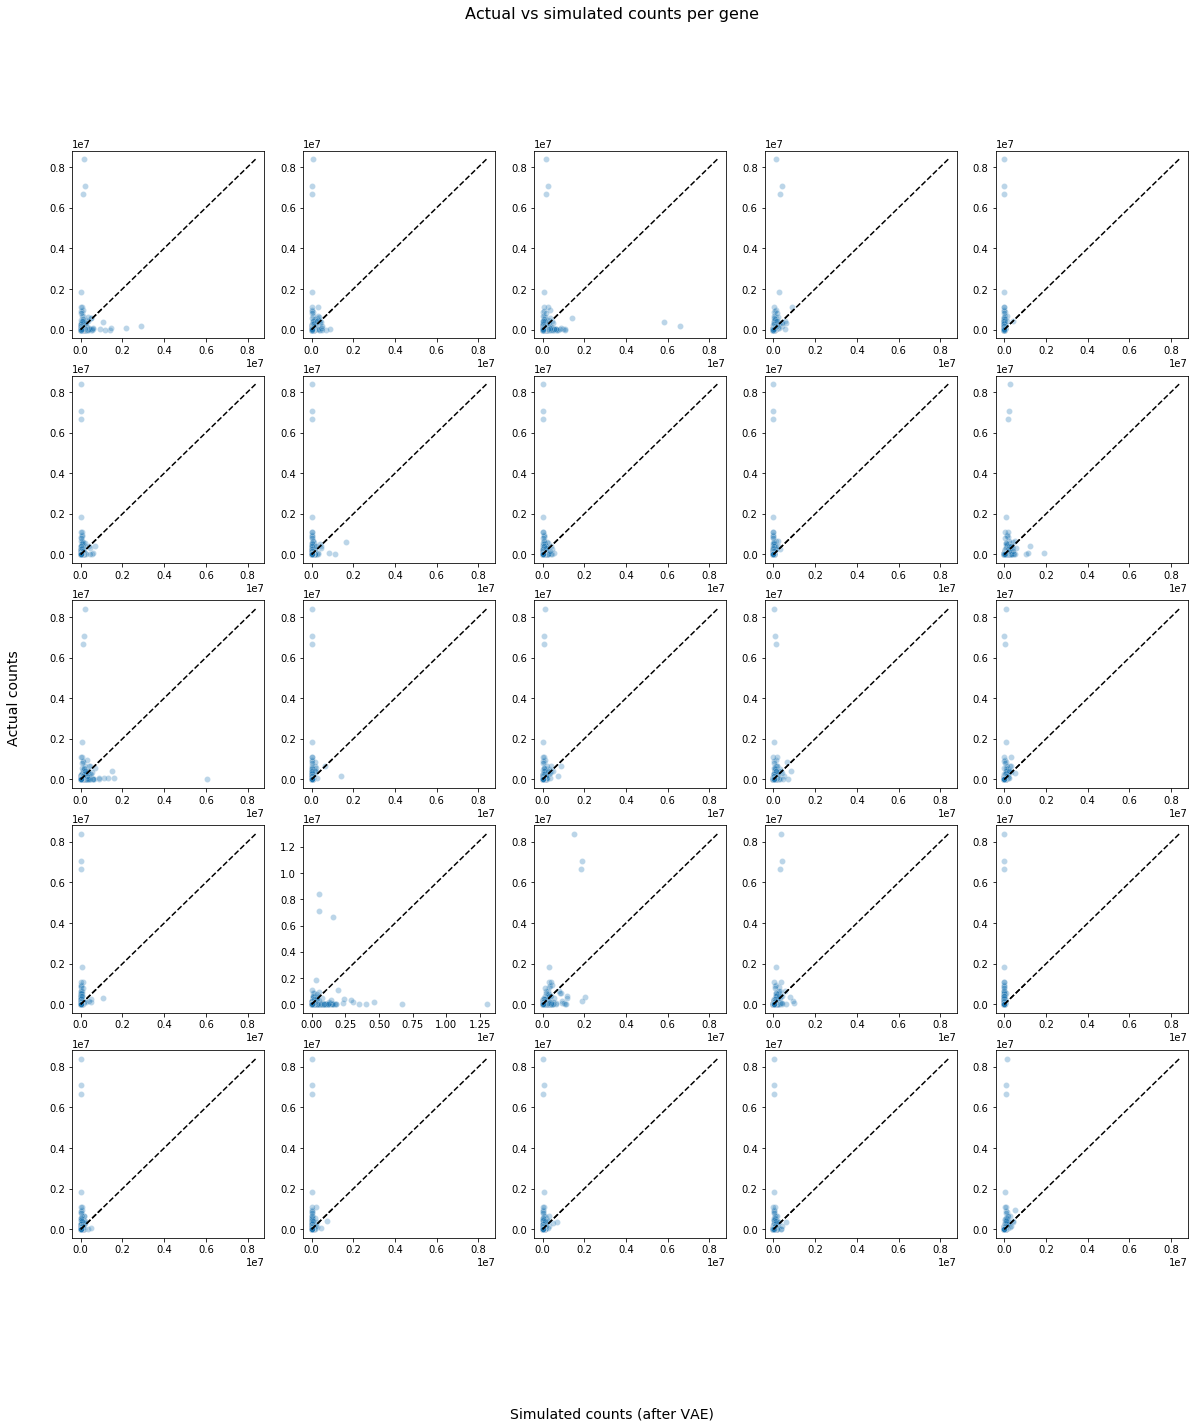

In [10]:
# Compare per gene for RNA-seq/array generic genes
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="gene",
    gene_list=correlated_genes,
)

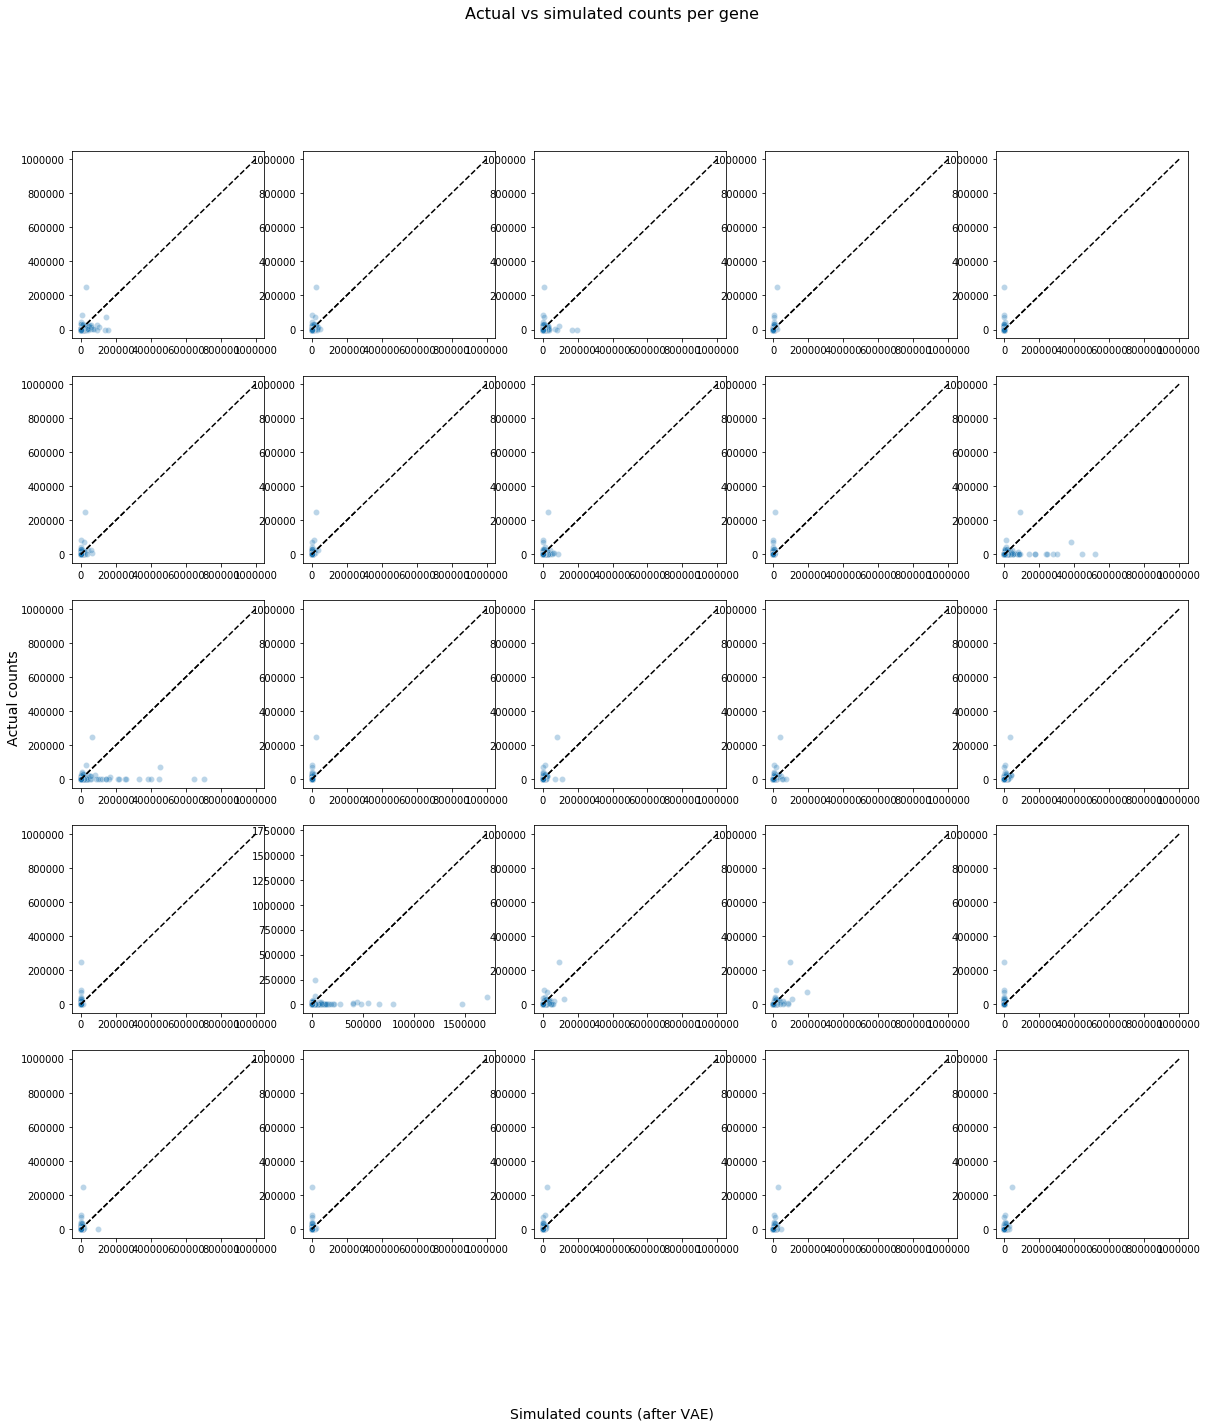

In [11]:
# Compare per sample for RNA-seq only generic genes
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="gene",
    gene_list=uncorrelated_genes,
)

## Examine per gene

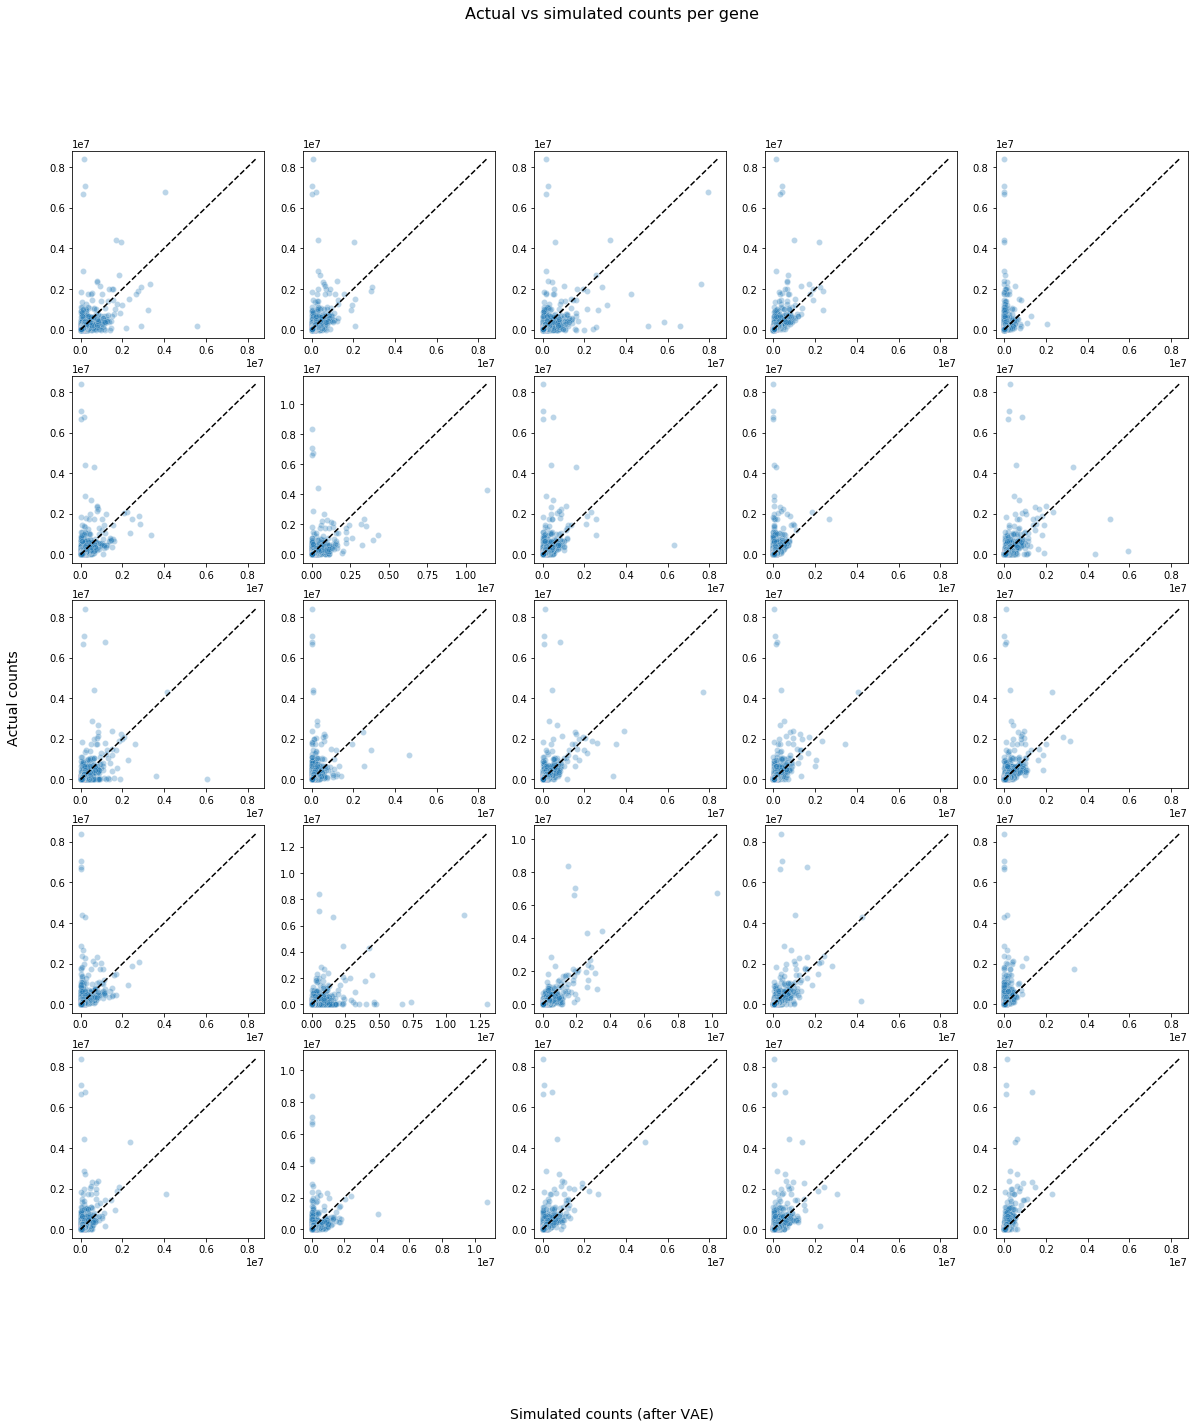

In [12]:
# Compare per gene
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="gene",
)

**Observations:**
* Since simulations are intended to produce different experiments, we don't expect the gene counts (activity) to be consistent between the actual vs simulated experiment which is what we see.

* Some genes that have high actual counts are reduced or increased in the simulated experiment

## Examine expression changes
* How does the mean expression of RNA-seq generic genes change after simulation? How does the variance change?
* We already know that the before expression of RNA-seq generic genes is low, what about after we simulate?
* How does the mean expression of array/RNA-seq generic genes change after simulation? How does the variance change?

In [13]:
# There are many 0 values throwing warning message
np.seterr(divide="ignore")


def violin_plot_original_vs_simulated(
    ncols,
    nrows,
    fig_width,
    fig_height,
    num_simulated,
    template_df,
    gene_list,
    if_rnaseq_only,
    if_mean,
):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, fig_height))
    axes = axes.ravel()

    for i in range(num_simulated):
        # Get simulated filename
        simulated_filename = os.path.join(
            simulated_dir, f"selected_simulated_data_{project_id}_{i}_processed.txt"
        )

        # Read simulated experiment
        simulated = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

        # Create dataframe for plotting
        if if_mean:
            stats_name = "mean_expression"
            if if_rnaseq_only:
                gene_group_name = "RNAseq_only"
                # Format mean df for plotting
                mean_dist = pd.DataFrame(
                    data={
                        "mean of RNAseq common DEGs (template)": np.log10(
                            template_df[gene_list].mean()
                        ),
                        "mean of RNAseq common DEGs (simulated)": np.log10(
                            simulated[gene_list].mean()
                        ),
                    }
                )
                colors = ["lightgrey", "#add8e6"]
            else:
                gene_group_name = "RNAseq_array"
                # Format mean df for plotting
                mean_dist = pd.DataFrame(
                    data={
                        "mean of array/RNAseq common DEGs (template)": np.log10(
                            template_df[gene_list].mean()
                        ),
                        "mean of array/RNAseq common DEGs (simulated)": np.log10(
                            simulated[gene_list].mean()
                        ),
                    }
                )
                colors = ["lightgrey", "#2c7fb8"]

            # Remove NA genes (i.e. genes not in gene list)
            # Drop -inf values
            mean_dist_processed = mean_dist.replace([np.inf, -np.inf], np.nan).dropna()

            # Violin plot of average expression of RNA-seq only generic genes
            f = sns.violinplot(
                data=mean_dist_processed, palette=colors, orient="h", ax=axes[i]
            )
            if i != 0:
                axes[i].set_yticklabels([])

            fig.text(
                0.5,
                0.0,
                "log10(average expression)",
                ha="center",
                fontsize=16,
                fontname="Verdana",
            )
            if if_rnaseq_only:
                fig.suptitle(
                    "Average expression of RNA-seq only common DEGs",
                    fontsize=16,
                    fontname="Verdana",
                )
            else:
                fig.suptitle(
                    "Average expression of RNA-seq/array common DEGs",
                    fontsize=16,
                    fontname="Verdana",
                )

        else:
            stats_name = "var_expression"
            if if_rnaseq_only:
                gene_group_name = "RNAseq_only"
                # Format var df for plotting
                var_dist = pd.DataFrame(
                    data={
                        "variance of RNAseq common DEGs (template)": np.log10(
                            template_df[gene_list].var()
                        ),
                        "variance of RNAseq common DEGs (simulated)": np.log10(
                            simulated[gene_list].var()
                        ),
                    }
                )
                colors = ["lightgrey", "#add8e6"]
            else:
                gene_group_name = "RNAseq_array"
                # Format var df for plotting
                var_dist = pd.DataFrame(
                    data={
                        "variance of array/RNAseq common DEGs (template)": np.log10(
                            template_df[gene_list].var()
                        ),
                        "variance of array/RNAseq common DEGs (simulated)": np.log10(
                            simulated[gene_list].var()
                        ),
                    }
                )
                colors = ["lightgrey", "#2c7fb8"]

            # Remove NA genes (i.e. genes not in gene list)
            # Drop -inf values
            var_dist_processed = var_dist.replace([np.inf, -np.inf], np.nan).dropna()

            # Violin plot of average expression of RNA-seq only generic genes
            f = sns.violinplot(
                data=var_dist_processed, palette=colors, orient="h", ax=axes[i]
            )
            if i != 0:
                axes[i].set_yticklabels([])

            fig.text(
                0.5,
                0.0,
                "log10(variance of expression)",
                ha="center",
                fontsize=16,
                fontname="Verdana",
            )
            if if_rnaseq_only:
                fig.suptitle(
                    "Variance of expression of RNA-seq only common DEGs",
                    fontsize=16,
                    fontname="Verdana",
                )
            else:
                fig.suptitle(
                    "Variance of expression of RNA-seq/array common DEGs",
                    fontsize=16,
                    fontname="Verdana",
                )
    f.get_figure().savefig(
        f"violin_plot_{stats_name}_{gene_group_name}.svg",
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )

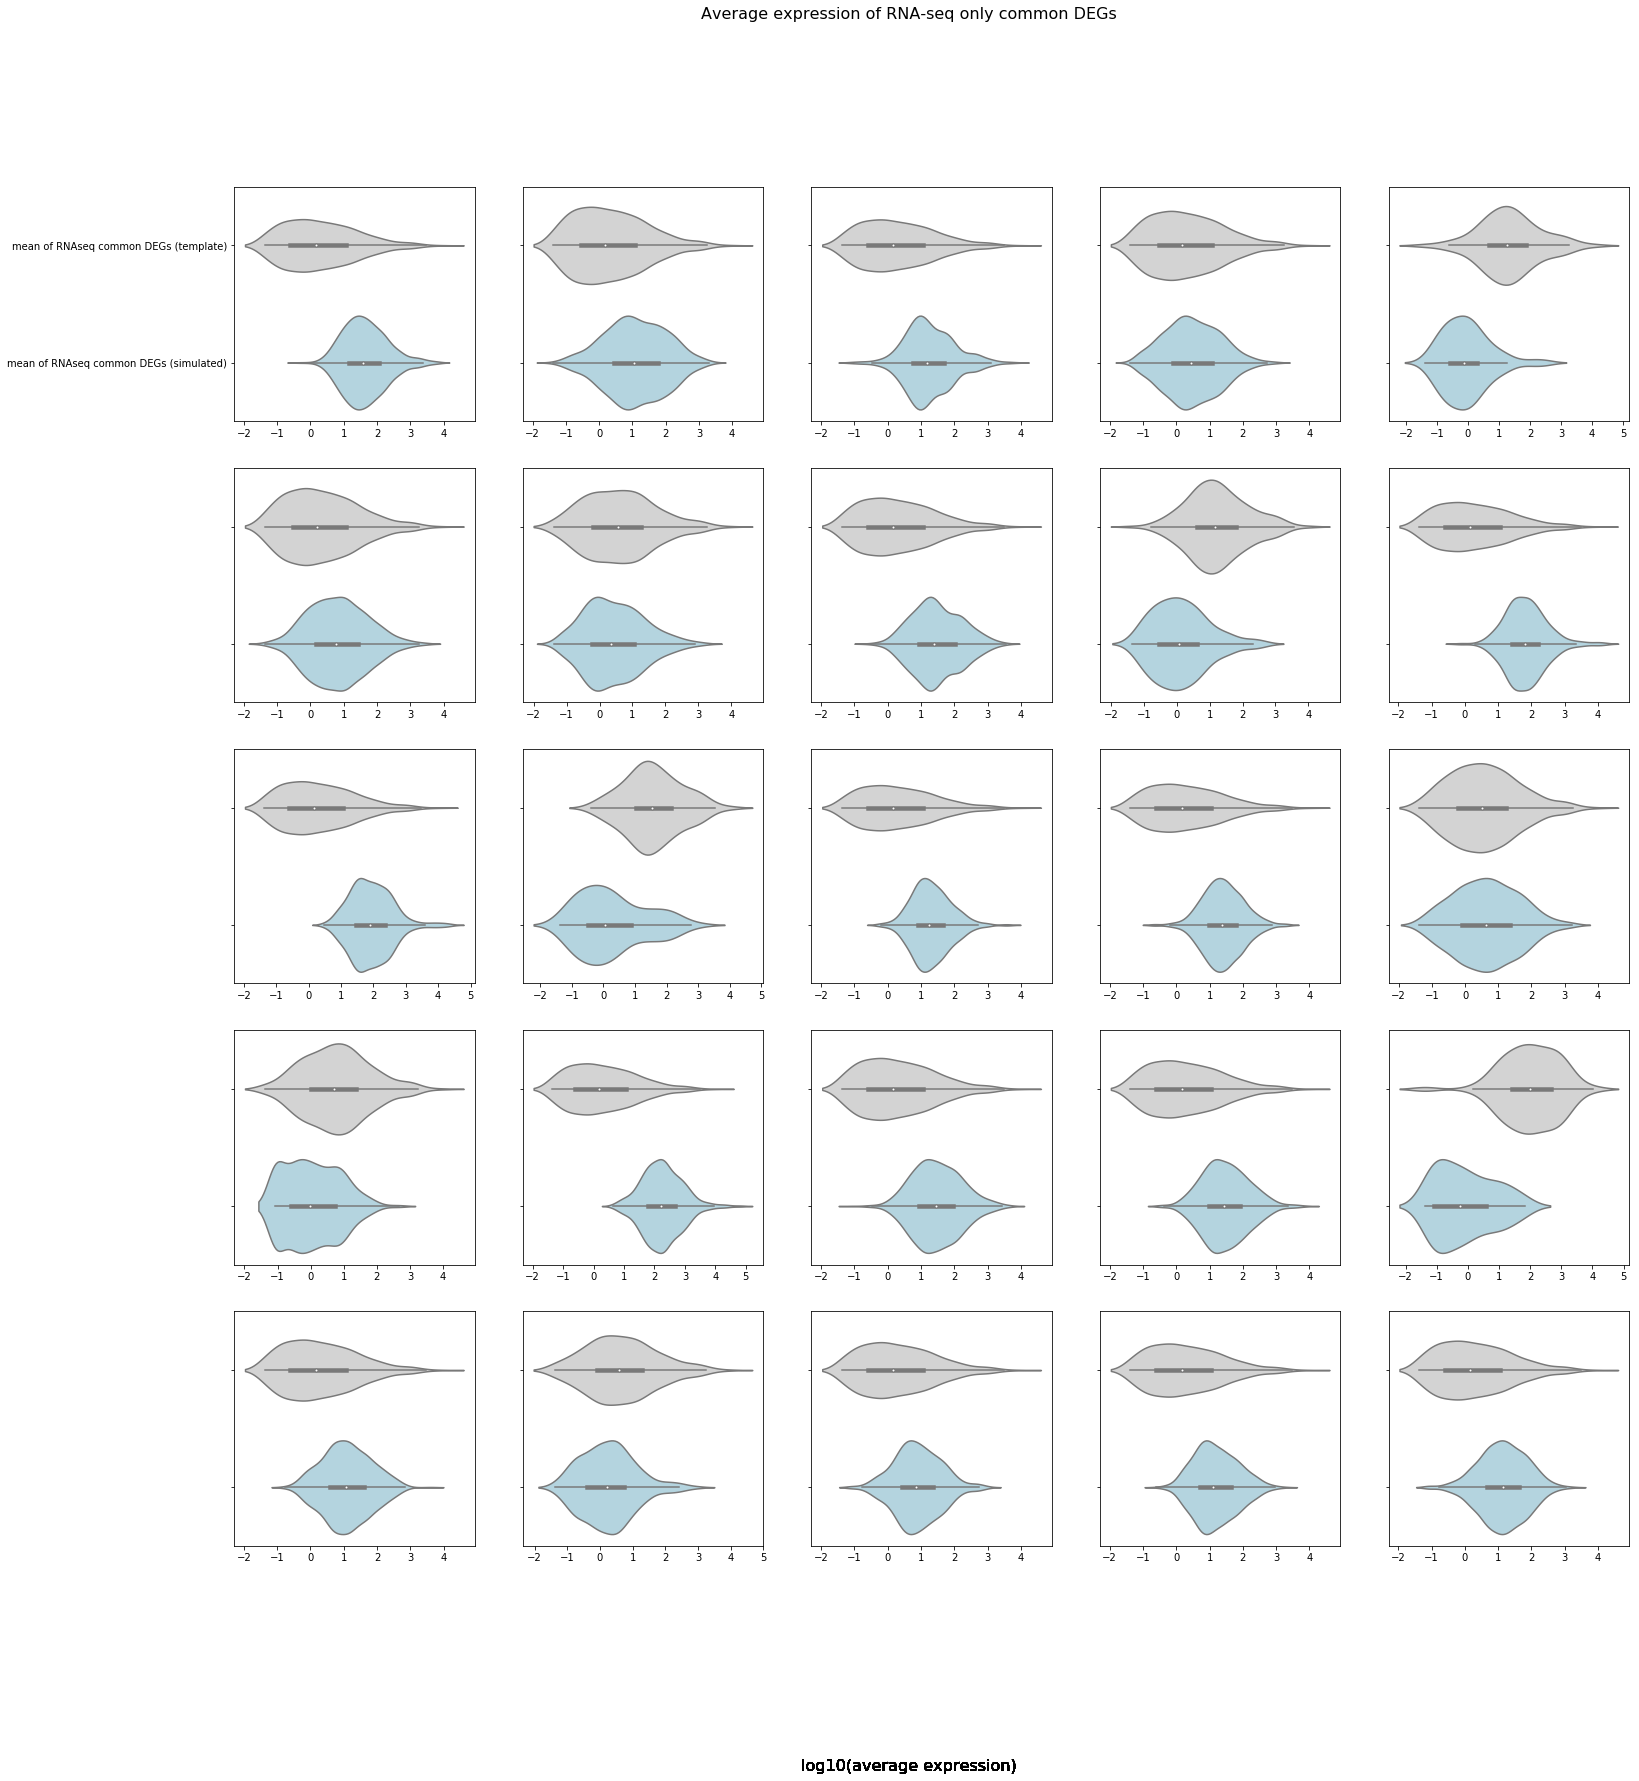

In [14]:
# Compare distribution of mean gene expression for RNA-seq only generic genes
violin_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=25,
    fig_height=25,
    num_simulated=25,
    template_df=template,
    gene_list=uncorrelated_genes,
    if_rnaseq_only=True,
    if_mean=True,
)

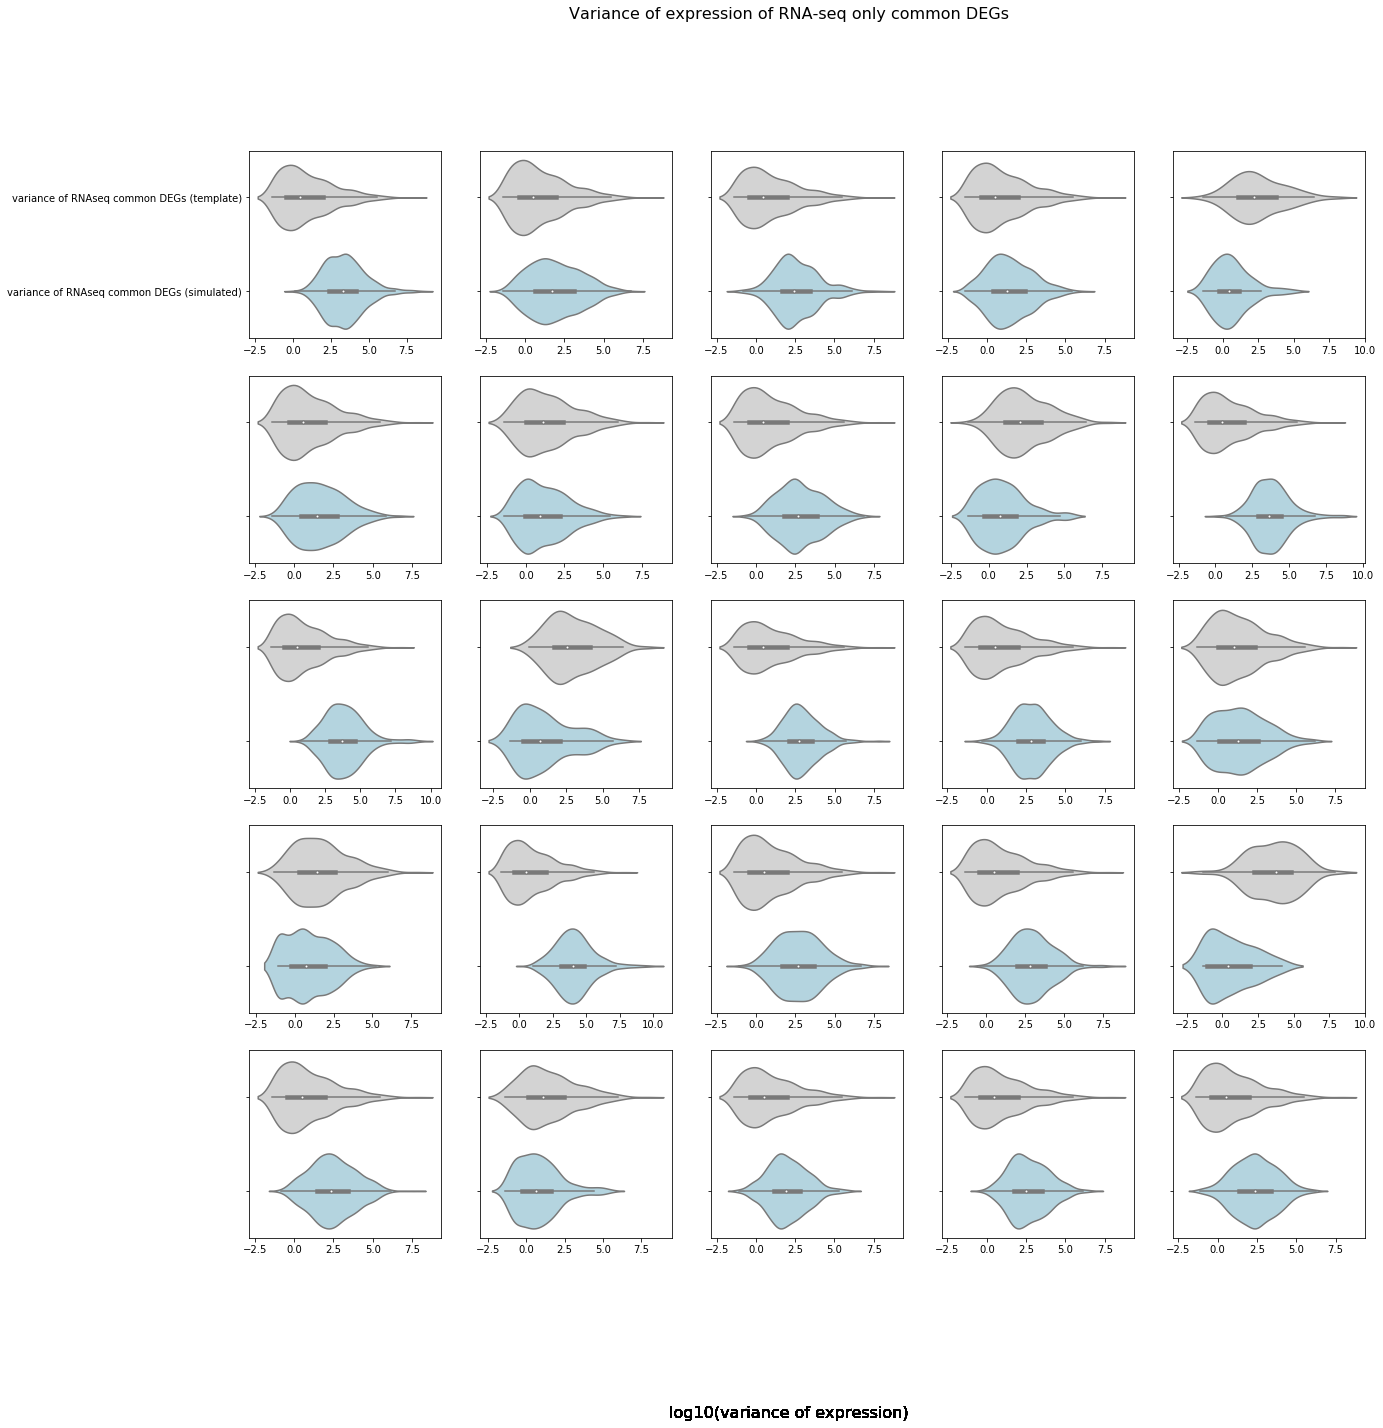

In [15]:
# Compare distribution of variance gene expression for RNA-seq only generic genes
violin_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    template_df=template,
    gene_list=uncorrelated_genes,
    if_rnaseq_only=True,
    if_mean=False,
)

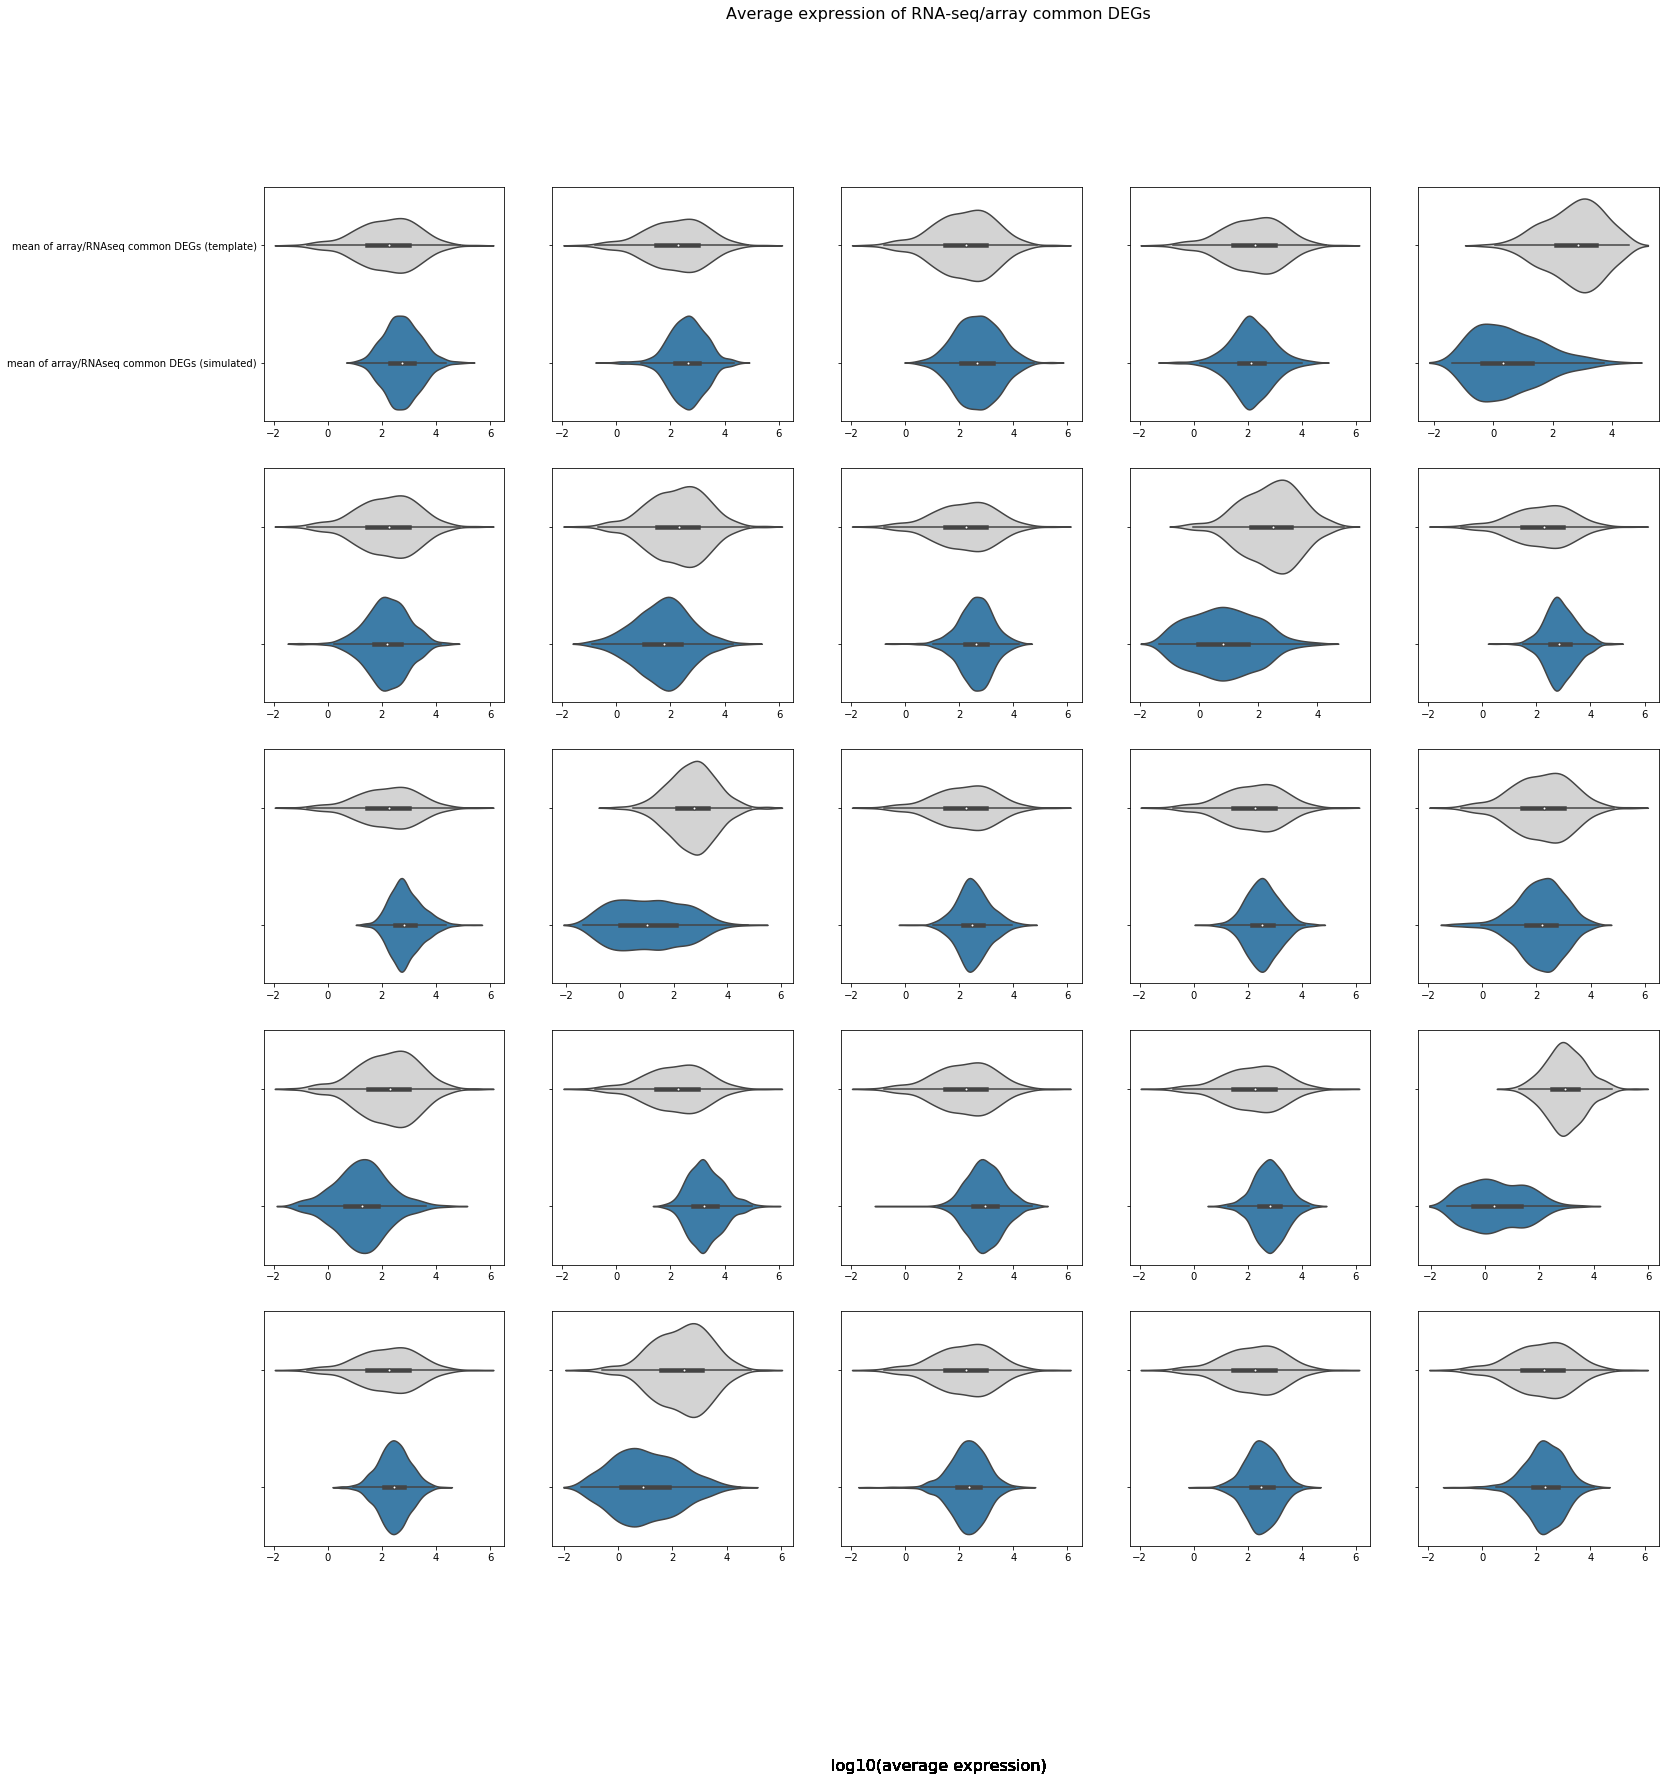

In [16]:
# Compare distribution of mean gene expression for RNA-seq/array generic genes
violin_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=25,
    fig_height=25,
    num_simulated=25,
    template_df=template,
    gene_list=correlated_genes,
    if_rnaseq_only=False,
    if_mean=True,
)

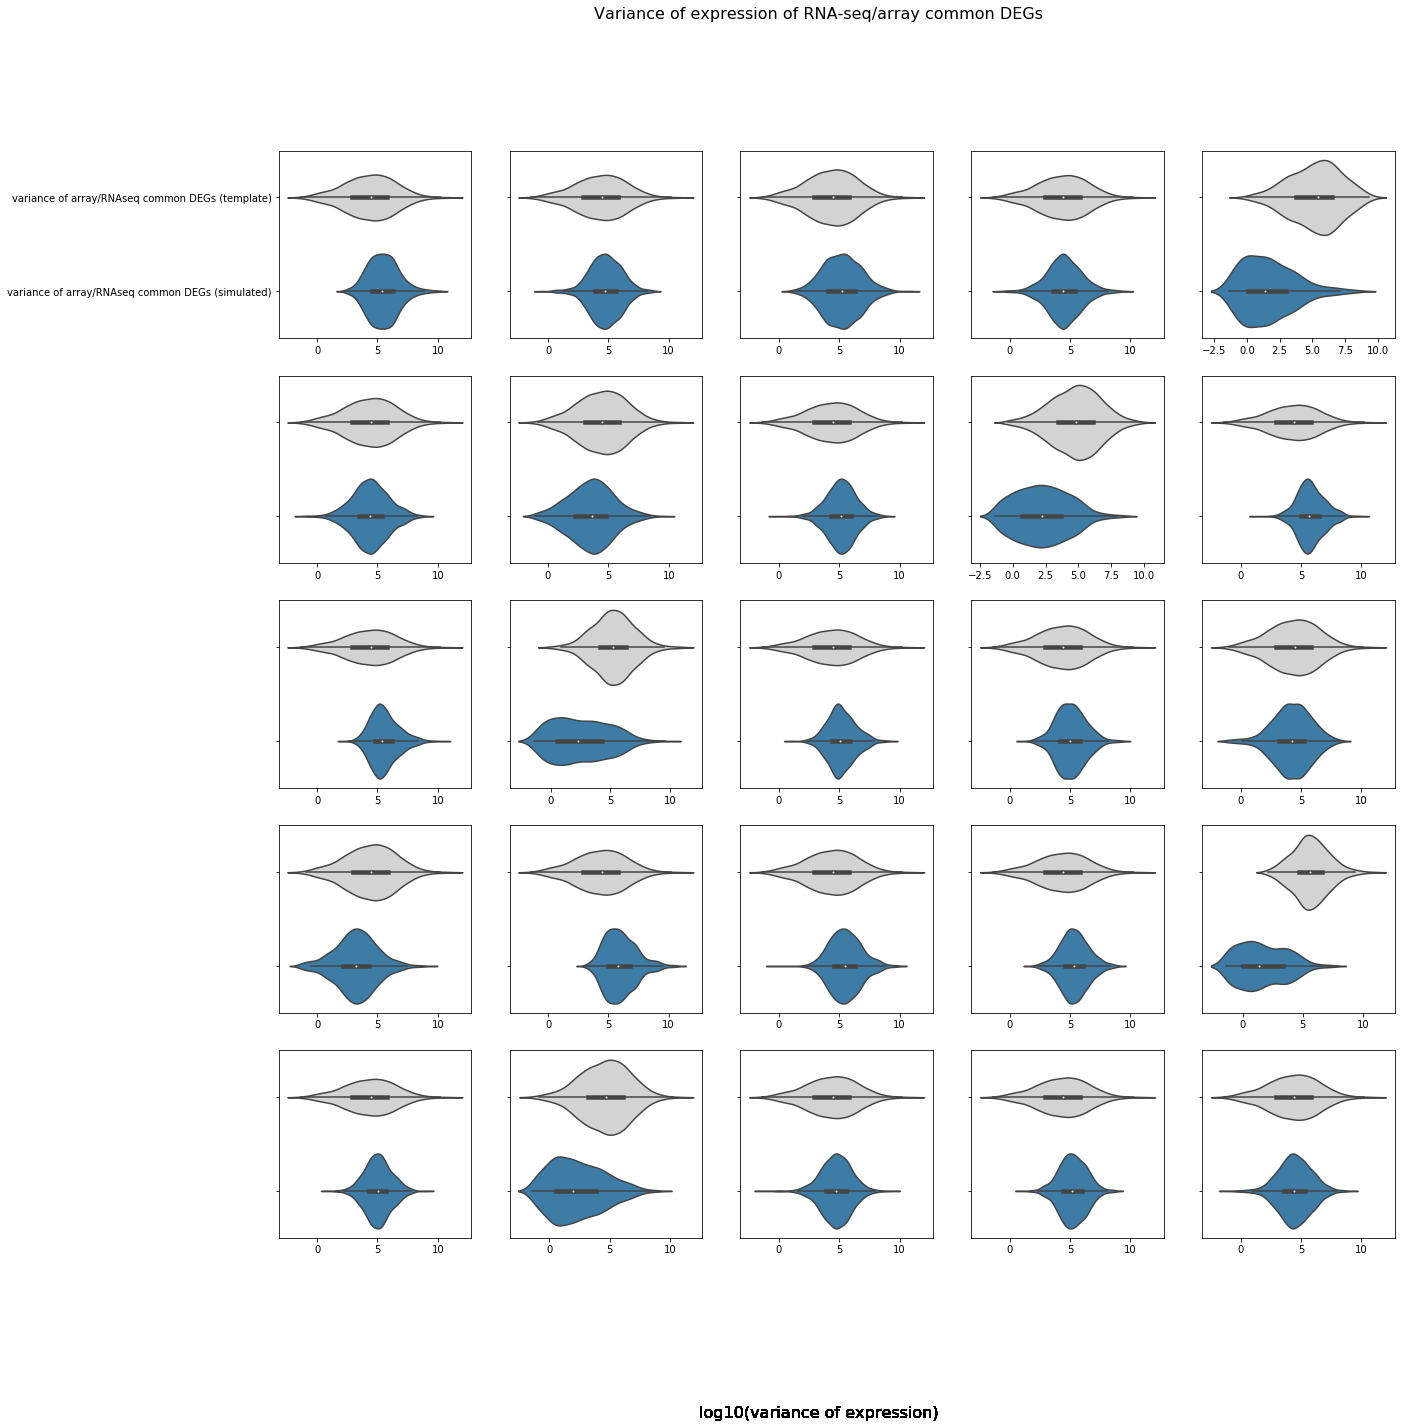

In [17]:
# Compare distribution of variance gene expression for RNA-seq/array generic genes
violin_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    template_df=template,
    gene_list=correlated_genes,
    if_rnaseq_only=False,
    if_mean=False,
)

**Takeaway:**
* For RNA-seq only generic genes:
    * The average simulated gene expression seems to be similar to the template or slightly increased
    * Similar trend see for the variance -- the variance in gene expression for simulated experiments seems to be similar or increased compared to the template experiment

* For RNA-seq and array generic genes:
    * The average simulated gene expression seems to be mostly similar to the template and a few cases where the average simulated expression was decreased
    * Similar trend seen in the variance -- the variance in gene expression for the simulated experiments seems to be similar or decreased compared to the template experiment.

* Overall, it appears that lower expression values in the template (which correspond to RNA-seq only generic genes) are changed more than genes with higher values
    * I believe this is likely due to the VAE compression -- possibly the ReLU activation function and/or gaussian constraint in the loss function.
    * Why does this compression not affect genes with higher expression values (RNA-seq/array generic genes) as much? This is probably because these values are closer to the mean expression of the compendium. The compression is probably affecting genes on the outliers of the distribution more.

* Why is this compression not seen in the array data?
    * In the array data, the gene expression for the RNA-seq only genes vs RNA-seq/array genes were similar in the array training compendium.
    * Overall the variance in array expression is lower compared to RNA-seq so there isnt' as much compression needed

* So genes with low gene expression in the real experiment are getting a boost/increase after going through VAE (simulated experiment) which allows them to be detected as DE.

**Possible solutions:**
* We don't want lowly expressed genes to get artificially detected as frequently DE.
* Would requiring varying parameters for the activation function and weighting for KL term in the loss function